In [36]:
## Setting up LangSmith for tracing 
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "ReAct-Agent"
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")

## **`ReAct Agent Architechture works in loop manner that call the tool perform a particular job and then go back to llm and llm further reason on it `**

In [9]:
model = 'qwen/qwen3-32b'

In [10]:
from langchain_groq import ChatGroq
llm = ChatGroq(model=model)

In [12]:
## Defining the state of Graph

from typing import Annotated , TypedDict
from langgraph.graph.message import add_messages # this is the reducer for appending messages in the list
from langchain_core.messages import AnyMessage , AIMessage , HumanMessage 
class State(TypedDict):
    messages : Annotated[list[AnyMessage] , add_messages]

In [23]:
def add(a , b):
    """
    Add two numbers a and b
    Args:
    a : first int
    b : Second int

    """
    return a + b
def multiplication(a , b):
    """
    multiply two numbers a and b
    Args:
    a : first int
    b : Second int

    """
    return a * b

In [37]:
from langchain_community.tools import ArxivQueryRun , WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper , WikipediaAPIWrapper
arxiv_api = ArxivAPIWrapper(top_k_results=2 , doc_content_chars_max=2000)
arxiv = ArxivQueryRun(api_wrapper=arxiv_api)

wikipedia_api = WikipediaAPIWrapper(top_k_results=2 , doc_content_chars_max=2000)
wikipedia = WikipediaQueryRun(api_wrapper=wikipedia_api)

from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

C:\Users\User\AppData\Local\Temp\ipykernel_6020\8954523.py:10: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [38]:
tools = [add , multiplication , wikipedia , arxiv , tavily]

In [39]:
## Binding LLM Tool

llm_with_tool = llm.bind_tools(tools)
# llm_with_tool.invoke([HumanMessage(content="what is 2 + 2" , name = "shahbaz")])


In [40]:
### Making LLM with Tool Node so that it act as brain and call the tools rightly

def llm_tool(state : State):
    
    return {'messages' : [llm_with_tool.invoke(state['messages'])]}

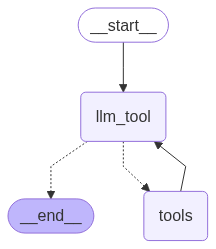

In [41]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode , tools_condition
builder = StateGraph(State)
## Adding nodes in LLM 
builder.add_node('llm_tool' , llm_tool)
builder.add_node('tools' , ToolNode(tools))

## Defining the WorkFlow

builder.add_edge(START , 'llm_tool')
builder.add_conditional_edges('llm_tool' , tools_condition)
builder.add_edge('tools' , 'llm_tool')

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
from pprint import pprint
messages = graph.invoke({"messages" : [HumanMessage(content="what is the current AI news and add 2 + 2")]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the current AI news and add 2 + 2
================================== Ai Message ==================================
Tool Calls:
  add (xgz5k4kfg)
 Call ID: xgz5k4kfg
  Args:
    a: 2
    b: 2
  tavily_search_results_json (xg7eyeatr)
 Call ID: xg7eyeatr
  Args:
    query: current AI news
================================= Tool Message =================================
Name: add

4
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News Briefs BULLETIN BOARD for July 2025", "url": "https://radicaldatascience.wordpress.com/2025/07/17/ai-news-briefs-bulletin-board-for-july-2025/", "content": "[7/14/2025] Moonshot AI’s Kimi K2 outperforms GPT-4 in key benchmarks – Chinese startup Moonshot AI released Kimi K2, a 1 trillion parameter open-source model that matches proprietary models on complex agentic tasks. The model was traine